In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import geohash as gh
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import *

Although K-means clustering has provided a broad picture of the general taxi routes in NYC, the precision is relatively low and not easy to analyze the taxi trips in areas with very dense traffic. In order to have a detailed picture of specific taxi routes in NYC, I use **Geohash** geocoding system to 'group' trips sharing similar pickup or dropoff locations. In geohash encoding, locations with coordinates close to each other will have the same encoded geohash string and thus could be grouped together. 

**Geohash**
https://www.movable-type.co.uk/scripts/geohash.html

Geohash is a public domain geocoding system that encodes a geographical location from coordinates to a string of letters and digits or decodes the string to coordinates reversely. Each unique geohash corresponds to a rectangular cell on map and the cell size can be specified with `precision`. 

Here is is the cell size corresponding to each precision:

**Geohash_length: Cell_width × Cell_height**
* 1: ≤ 5,000km × 5,000km
* 2: ≤ 1,250km × 625km
* 3: ≤ 156km × 156km
* 4: ≤ 39.1km × 19.5km
* 5: ≤ 4.89km ×	4.89km
* 6: ≤ 1.22km ×	0.61km
* 7: ≤ 153m	× 153m
* 8: ≤ 38.2m × 19.1m
* 9: ≤ 4.77m × 4.77m
* 10: ≤ 1.19m ×	0.596m
* 11: ≤ 149mm ×	149mm
* 12: ≤ 37.2mm × 18.6mm

# 1. Encode and decode the geohash info (cluster)

Due to the large size of the total trip records, Geohash encoding is performed in cluster. The larger the precision is, the smaller the cell size with higher resolution of the encoded system. However, the number of unique geohash labels will increase with higher resolution and leads to large file size as well as being more difficult to group trips with similar pickup and dropoff locations. Thus, to keep a balance between resolution (accuracy) as well as grouping efficiency, I chose precision = 6.

**Note**: The input file here has been further filtered based on the bounding box defined in the previous notebook as well as trip_duration > 0. The current number of records is **18817820** (compared to 18886623 after filtering in the previous notebook).

In [2]:
def gh_encode_pick(x):
    return gh.encode(x.pickup_latitude, x.pickup_longitude, precision = 6)
def gh_encode_drop(x):
    return gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision = 6)

def gh_decode_pick_lat(x):
    return gh.decode(x.pickup_gh6)[0]
def gh_decode_pick_long(x):
    return gh.decode(x.pickup_gh6)[1]
def gh_decode_drop_lat(x):
    return gh.decode(x.dropoff_gh6)[0]
def gh_decode_drop_long(x):
    return gh.decode(x.dropoff_gh6)[1]

In [ ]:
dirpath = "/data/chenge/xiey1/DataScience/NYC_taxi/nyc_taxi_green_2015_combine"
filename_combine_filter = "nyc_taxi_green_2015_combine_filter.csv"
file = os.path.join(dirpath, filename_combine_filter)

In [ ]:
data = pd.read_csv(file, parse_dates=["pickup_datetime", "dropoff_datetime"])
data['pickup_gh6'] = data.apply(gh_encode_pick, axis = 1)
data['dropoff_gh6'] = data.apply(gh_encode_drop, axis = 1)
data_pickup_gh6_unique = len(data.pickup_gh6.unique())
data_dropoff_gh6_unique = len(data.dropoff_gh6.unique())
data['pickup_gh6_lat'] = data.apply(gh_decode_pick_lat, axis = 1)
data['pickup_gh6_long'] = data.apply(gh_decode_pick_long, axis = 1)
data['dropoff_gh6_lat'] = data.apply(gh_decode_drop_lat, axis = 1)
data['dropoff_gh6_long'] = data.apply(gh_decode_drop_long, axis = 1)
data.to_csv(os.path.join(dirpath, 'nyc_taxi_green_2015_pre_v2_gh6annot.csv'), index = False)

In [ ]:
features_1 = ['weekday', 'hour', 'month', 'day_of_year', 'pickup_gh6', 'pickup_gh6_lat', 'pickup_gh6_long']
data_groupbygh_pick = data.groupby(features_1, as_index = False).count()[features_1 + ['trip_ID']]
data_groupbygh_pick.to_csv(os.path.join(dirpath, 'nyc_taxi_green_2015_pre_2_gh6_pick_v1.csv'), index = False)

In [ ]:
features_2 = ['weekday', 'hour', 'month', 'day_of_year', 'dropoff_gh6', 'dropoff_gh6_lat', 'dropoff_gh6_long']
data_groupbygh_drop = data.groupby(features_2, as_index = False).count()[features_2 + ['trip_ID']]
data_groupbygh_drop.to_csv(os.path.join(dirpath, 'nyc_taxi_green_2015_pre_2_gh6_drop_v1.csv'), index = False)

In [ ]:
features_3 = ['weekday', 'hour', 'month', 'day_of_year', 'pickup_gh6', 'pickup_gh6_lat', 'pickup_gh6_long', 'dropoff_gh6', 'dropoff_gh6_lat', 'dropoff_gh6_long']
data_groupbygh_trip = data.groupby(features_3, as_index = False).count()[features_3 + ['trip_ID']]
data_groupbygh_trip.to_csv(os.path.join(dirpath, 'nyc_taxi_green_2015_pre_2_gh6_trip_v1.csv'), index = False)

# 2. Analyze the unique pickup, dropoff locations and obtain unique routes

In [3]:
taxi_green_gh6_pick = pd.read_csv('geohash/nyc_taxi_green_2015_pre_2_gh6_pick_v1.csv')
taxi_green_gh6_drop = pd.read_csv('geohash/nyc_taxi_green_2015_pre_2_gh6_drop_v1.csv')
taxi_green_gh6_trip = pd.read_csv('geohash/nyc_taxi_green_2015_pre_2_gh6_trip_v1.csv')
taxi_green_gh6_pick.rename(columns = {'trip_ID':'trip_number'}, inplace = True)
taxi_green_gh6_drop.rename(columns = {'trip_ID':'trip_number'}, inplace = True)
taxi_green_gh6_trip.rename(columns = {'trip_ID':'trip_number'}, inplace = True)

In [4]:
taxi_green_gh6_pick = taxi_green_gh6_pick.sort_values(by=['trip_number'], ascending = False)
taxi_green_gh6_drop = taxi_green_gh6_drop.sort_values(by=['trip_number'], ascending = False)
taxi_green_gh6_trip = taxi_green_gh6_trip.sort_values(by=['trip_number'], ascending = False)

In [5]:
print('taxi_green_gh6_pick file_size: {}'.format(taxi_green_gh6_pick.shape))
print('taxi_green_gh6_drop file_size: {}'.format(taxi_green_gh6_drop.shape))
print('taxi_green_gh6_trip file_size: {}'.format(taxi_green_gh6_trip.shape))

taxi_green_gh6_pick file_size: (2345149, 8)
taxi_green_gh6_drop file_size: (4055396, 8)
taxi_green_gh6_trip file_size: (14934472, 11)


In [6]:
taxi_green_gh6_pick.head()

,weekday,hour,month,day_of_year,pickup_gh6,pickup_gh6_lat,pickup_gh6_long,trip_number
2028893,6,1,11,305,dr5rsg,40.712585,-73.965454,378
2028901,6,1,11,305,dr5rt5,40.712585,-73.954468,344
2047688,6,3,1,11,dr5rtj,40.723572,-73.954468,337
2028991,6,1,11,305,dr5ry9,40.745544,-73.888550,329
1644514,5,0,12,346,dr5ry9,40.745544,-73.888550,320


In [7]:
taxi_green_gh6_drop.head()

,weekday,hour,month,day_of_year,dropoff_gh6,dropoff_gh6_lat,dropoff_gh6_long,trip_number
3927223,6,19,4,102,dr5rkw,40.685120,-73.976440,169
2676347,4,19,5,121,dr5rkw,40.685120,-73.976440,159
3317346,5,19,6,178,dr5rkw,40.685120,-73.976440,152
3515033,6,1,11,305,dr5rt5,40.712585,-73.954468,150
3231452,5,16,8,234,dr5rs8,40.696106,-73.976440,137


In [8]:
taxi_green_gh6_trip.head()

,weekday,hour,month,day_of_year,pickup_gh6,pickup_gh6_lat,pickup_gh6_long,dropoff_gh6,dropoff_gh6_lat,dropoff_gh6_long,trip_number
4873339,2,18,10,280,dr5rkr,40.690613,-73.987427,dr5rkn,40.685120,-73.998413,41
4873336,2,18,10,280,dr5rkr,40.690613,-73.987427,dr5rkj,40.679626,-73.998413,39
4966305,2,19,7,182,dr5rkr,40.690613,-73.987427,dr5rkj,40.679626,-73.998413,38
11634722,5,18,3,87,dr72hu,40.805969,-73.965454,dr72hd,40.794983,-73.976440,37
10091958,5,1,4,115,dr5ry9,40.745544,-73.888550,dr5rz4,40.751038,-73.866577,34


In [9]:
print('unique number of pickup_gh6 points: {}'.format(len(taxi_green_gh6_pick.pickup_gh6.unique())))
print('unique number of dropoff_gh6 points: {}'.format(len(taxi_green_gh6_drop.dropoff_gh6.unique())))

unique number of pickup_gh6 points: 1785
unique number of dropoff_gh6 points: 2397


In [10]:
taxi_green_gh6_trip_groupby_route = taxi_green_gh6_trip.groupby(['pickup_gh6', 'dropoff_gh6', 'pickup_gh6_long', 'pickup_gh6_lat', 'dropoff_gh6_long', 'dropoff_gh6_lat']).sum()[['trip_number']]
taxi_green_gh6_trip_groupby_route.reset_index(inplace = True)
print('number of unique routes: {}'.format(taxi_green_gh6_trip_groupby_route.shape[0]))
# taxi_green_gh6_trip_groupby_route.to_csv('geohash/nyc_taxi_green_gh6_trip_groupby_route.csv', index = False)

number of unique routes: 285293


In [11]:
taxi_green_gh6_trip_groupby_route = taxi_green_gh6_trip_groupby_route.sort_values(by = ['trip_number'], ascending = False)
taxi_green_gh6_trip_groupby_route['rank'] = np.arange(taxi_green_gh6_trip_groupby_route.shape[0])+1
taxi_green_gh6_trip_groupby_route.head()

,pickup_gh6,dropoff_gh6,pickup_gh6_long,pickup_gh6_lat,dropoff_gh6_long,dropoff_gh6_lat,trip_number,rank
160492,dr5ry9,dr5rye,-73.888550,40.745544,-73.888550,40.756531,30672,1
160494,dr5ry9,dr5ryg,-73.888550,40.745544,-73.877563,40.756531,30084,2
214885,dr72j1,dr5rvp,-73.954468,40.789490,-73.954468,40.778503,29711,3
108713,dr5rth,dr5rtn,-73.954468,40.718079,-73.954468,40.729065,26757,4
160493,dr5ry9,dr5ryf,-73.888550,40.745544,-73.877563,40.751038,26612,5


[]

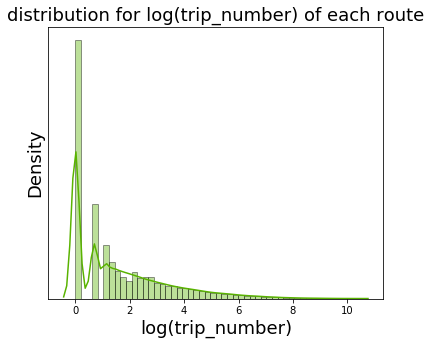

In [12]:
## Check image size distribution
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.distplot(np.log(taxi_green_gh6_trip_groupby_route.trip_number), bins=50, hist_kws={'edgecolor':'black'}, color='#59b300')
ax.set_title('distribution for log(trip_number) of each route', fontsize=18)
ax.set_xlabel('log(trip_number)', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.set_yticks([])

In [15]:
taxi_green_gh6_trip_groupby_route.trip_number.quantile(np.arange(0,1,0.1))

0.0     1.0
0.1     1.0
0.2     1.0
0.3     1.0
0.4     2.0
0.5     3.0
0.6     5.0
0.7     9.0
0.8    19.0
0.9    66.0
Name: trip_number, dtype: float64

In [16]:
total_trip = taxi_green_gh6_trip_groupby_route.trip_number.sum()
print('Total number of trips for NYC green taxi: {}'.format(total_trip))
trip_365_df = taxi_green_gh6_trip_groupby_route[taxi_green_gh6_trip_groupby_route.trip_number >= 365]
print('Total number of routes with more than 365 trips: {}'.format(trip_365_df.shape[0]))
trip_365 = trip_365_df.trip_number.sum()
print('Total number of trips for routes with more than 365 trips: {}'.format(trip_365))

Total number of trips for NYC green taxi: 18817820
Total number of routes with more than 365 trips: 8712
Total number of trips for routes with more than 365 trips: 13853266


**The most popular 8712 routes out of 285293 (3.05%) total unique routes for NYC green taxi account for 13853266 out of 18817820 (73.62%) total trips in year 2015**

In [17]:
taxi_green_gh6_trip_groupby_route_top10 = taxi_green_gh6_trip_groupby_route.iloc[:10,:]
print('Total number of trips for top10 most popular routes: {}({:.2f}%)'.format(taxi_green_gh6_trip_groupby_route_top10.trip_number.sum(), taxi_green_gh6_trip_groupby_route_top10.trip_number.sum()/total_trip*100))

Total number of trips for top10 most popular routes: 267974(1.42%)


In [18]:
taxi_green_gh6_trip_groupby_route_top10.head()

,pickup_gh6,dropoff_gh6,pickup_gh6_long,pickup_gh6_lat,dropoff_gh6_long,dropoff_gh6_lat,trip_number,rank
160492,dr5ry9,dr5rye,-73.888550,40.745544,-73.888550,40.756531,30672,1
160494,dr5ry9,dr5ryg,-73.888550,40.745544,-73.877563,40.756531,30084,2
214885,dr72j1,dr5rvp,-73.954468,40.789490,-73.954468,40.778503,29711,3
108713,dr5rth,dr5rtn,-73.954468,40.718079,-73.954468,40.729065,26757,4
160493,dr5ry9,dr5ryf,-73.888550,40.745544,-73.877563,40.751038,26612,5


In [19]:
taxi_green_gh6_trip_groupby_route_top20 = taxi_green_gh6_trip_groupby_route.iloc[:20,:]
print('Total number of trips for top20 most popular routes: {}({:.2f}%)'.format(taxi_green_gh6_trip_groupby_route_top20.trip_number.sum(), taxi_green_gh6_trip_groupby_route_top20.trip_number.sum()/total_trip*100))

Total number of trips for top20 most popular routes: 487721(2.59%)


# 3. Visualize the top10 and top20 most popular routes

In order to compare the result from geohash with result obtained from the previous K-means clustering, the routes will be drawn on the previous clustering map.

In [20]:
LL = (-74.30, -73.70, 40.56, 40.90)

In [21]:
cl_green_df = pd.read_csv('cluster_kmeans/nyc_taxi_green_2015_combine_1000000_filter_kmeans15_joint.csv')
centroid_green = pd.read_csv('cluster_kmeans/nyc_taxi_green_2015_combine_1000000_filter_kmeans15_joint_centroid.csv')

In [29]:
def plot_cluster2(df, taxi, centroid, cluster_n, route_df, route_n, arrow_col,title):
    def get_cmap(n, name='tab20'):   ## name = 'hsv'
        return plt.cm.get_cmap(name, n)
    cl_to_label_dict = {i:'cluster'+str(i) for i in np.arange(cluster_n)}
    color_list = get_cmap(cluster_n, name = 'tab20')
    colors = {'green':'#59b300', 'yellow':'#ff9900'}
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    for i in np.arange(cluster_n):
        ax.scatter(np.array(df[df.pick_cl == i].pickup_longitude), np.array(df[df.pick_cl == i].pickup_latitude), marker='.', alpha = 0.3, s = 0.3, color = color_list(i), label=cl_to_label_dict[i], zorder=0)
        ax.scatter(np.array(df[df.drop_cl == i].dropoff_longitude), np.array(df[df.drop_cl == i].dropoff_latitude), marker='.', alpha = 0.3, s = 0.3, color = color_list(i), zorder=0)
    
    leg = ax.legend(loc = 'upper left', edgecolor = colors[taxi])
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [60]
    
    ax.set_xlim((LL[0], LL[1]))
    ax.set_ylim(LL[2], LL[3])
    ax.set_title(title, fontsize=20)
    
    route_df = route_df.iloc[:route_n,:]
    ax.plot(route_df.pickup_gh6_long, route_df.pickup_gh6_lat, 'o', color = 'r')
    ax.plot(route_df.dropoff_gh6_long, route_df.dropoff_gh6_lat, '*', color = 'b')
    for i in np.arange(route_n): 
        dist_x = route_df.iloc[i,:].pickup_gh6_long - route_df.iloc[i,:].dropoff_gh6_long
        dist_y = route_df.iloc[i,:].pickup_gh6_lat - route_df.iloc[i,:].dropoff_gh6_lat
        pct = np.true_divide(route_df.iloc[i,:].trip_number,route_df.trip_number.sum())
        #arr = Arrow(centroid.centroid_pick_long[centroid.pick_cl == i].values, centroid.centroid_pick_lat[centroid.pick_cl == i].values, -dist_x, -dist_y, edgecolor='white', width = 30*pct)
        arr = Arrow(route_df.iloc[i,:].pickup_gh6_long, route_df.iloc[i,:].pickup_gh6_lat, -dist_x, -dist_y, width = 0.05*pct, zorder=1)
        ax.add_patch(arr)
        arr.set_facecolor(arrow_col)

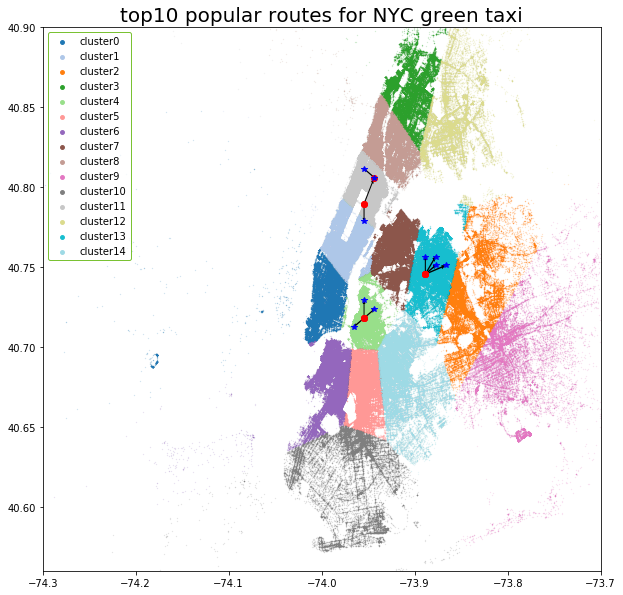

In [30]:
title = 'top10 popular routes for NYC green taxi'
plot_cluster2(df=cl_green_df, taxi='green', centroid=centroid_green, cluster_n=15, route_df = taxi_green_gh6_trip_groupby_route, route_n=10,arrow_col='black', title = title)

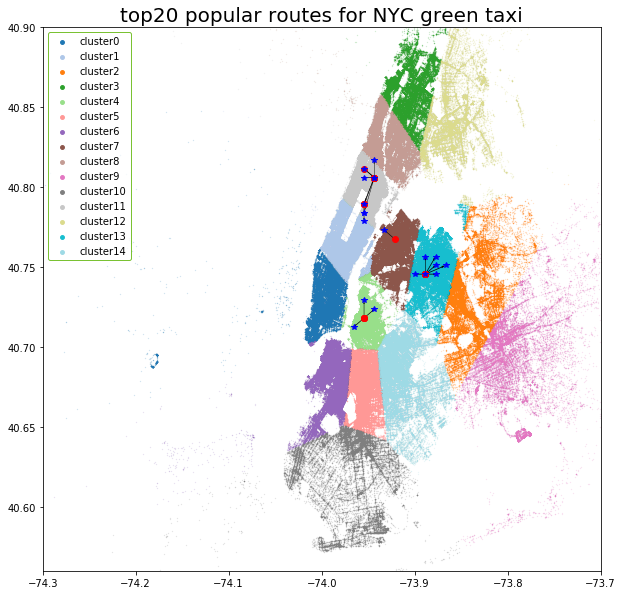

In [31]:
title = 'top20 popular routes for NYC green taxi'
plot_cluster2(df=cl_green_df, taxi='green', centroid=centroid_green, cluster_n=15, route_df = taxi_green_gh6_trip_groupby_route,route_n = 20, arrow_col='black', title = title)

In [26]:
import folium
def clusters_map(df, tile = 'OpenStreetMap', zoom = 12, radius = 30):
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=zoom,tiles='OpenStreetMap')
    for i in np.arange(df.shape[0]):
        rank = df.shape[0]-i
        route = df.iloc[i,]
        trip_number = route.trip_number
        pop = 'rank'+str(rank)+' & number of trips =' + str(trip_number)
        folium.CircleMarker(location=[route.pickup_gh6_lat, route.pickup_gh6_long], radius=radius, color='#F08080',fill_color='#F08080', popup=pop).add_to(map_1)
        folium.CircleMarker(location=[route.dropoff_gh6_lat, route.dropoff_gh6_long], radius=radius, color='#3186cc',fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([route.pickup_gh6_lat, route.pickup_gh6_long], popup=pop).add_to(map_1)
    return map_1

In [27]:
df = taxi_green_gh6_trip_groupby_route_top10.sort_values(by = 'trip_number')
clusters_map(df, tile = 'OpenStreetMap', zoom = 12, radius = 10)

In [28]:
df = taxi_green_gh6_trip_groupby_route_top20.sort_values(by = 'trip_number')
clusters_map(df, tile = 'OpenStreetMap', zoom = 12, radius = 10)

The top10 popular routes is distributed in 3 areas: Jackson Heights, McCarren Park and Harlem.  The top20 popular routes has similar distribution with an additional popular route in Astoria in Queens.

Here, I will focus on the routes that start from Jackson Heights (4/10), McCarren Park (3/10) and Harlem (3/10).

## 3.1 Routes start from Jackson Heights

In [83]:
gh6_JH = taxi_green_gh6_trip_groupby_route_top10.iloc[0,:].pickup_gh6
gh6_long_JH = taxi_green_gh6_trip_groupby_route_top10.iloc[0,:].pickup_gh6_long
gh6_lat_JH = taxi_green_gh6_trip_groupby_route_top10.iloc[0,:].pickup_gh6_lat

In [123]:
gh6_JH_drop_ghs = np.array(taxi_green_gh6_trip_groupby_route_top10[taxi_green_gh6_trip_groupby_route_top10.pickup_gh6 == gh6_JH].dropoff_gh6)
print('pickup location geohash label: {}'.format(gh6_JH))
print('dropoff locations geohash label: {}'.format(gh6_JH_drop_ghs))

pickup location geohash label: dr5ry9
dropoff locations geohash label: ['dr5rye' 'dr5ryg' 'dr5ryf' 'dr5rz4']


In [95]:
taxi_green_gh6_trip_top10_JH = taxi_green_gh6_trip[(taxi_green_gh6_trip.pickup_gh6==gh6_JH)&((taxi_green_gh6_trip.dropoff_gh6 == gh6_JH_drop_ghs[0])|(taxi_green_gh6_trip.dropoff_gh6 == gh6_JH_drop_ghs[1])|(taxi_green_gh6_trip.dropoff_gh6 == gh6_JH_drop_ghs[2])|(taxi_green_gh6_trip.dropoff_gh6 == gh6_JH_drop_ghs[3]))]

In [141]:
taxi_green_gh6_trip_top10_JH.shape

(29335, 11)

In [97]:
taxi_green_gh6_trip_top10_JH.head()

,weekday,hour,month,day_of_year,pickup_gh6,pickup_gh6_lat,pickup_gh6_long,dropoff_gh6,dropoff_gh6_lat,dropoff_gh6_long,trip_number
10091958,5,1,4,115,dr5ry9,40.745544,-73.88855,dr5rz4,40.751038,-73.866577,34
9942658,5,0,4,115,dr5ry9,40.745544,-73.88855,dr5rz4,40.751038,-73.866577,33
10042883,5,0,12,346,dr5ry9,40.745544,-73.88855,dr5ryf,40.751038,-73.877563,30
12988704,6,2,6,172,dr5ry9,40.745544,-73.88855,dr5rz4,40.751038,-73.866577,23
10201838,5,2,2,59,dr5ry9,40.745544,-73.88855,dr5rz4,40.751038,-73.866577,22


Text(0.5, 1.0, 'Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Jackson Heights')

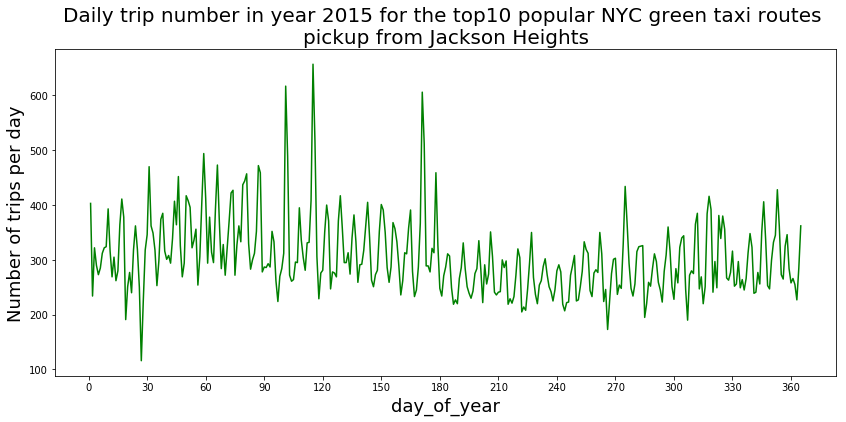

In [109]:
taxi_green_gh6_trip_top10_JH_dayofyear = taxi_green_gh6_trip_top10_JH.groupby(['day_of_year'], as_index = False).sum()[['day_of_year', 'trip_number']]
fig = plt.figure(figsize = (14,6))
plt.plot(taxi_green_gh6_trip_top10_JH_dayofyear.day_of_year, taxi_green_gh6_trip_top10_JH_dayofyear.trip_number, color = 'green')
plt.xlabel('day_of_year', fontsize = 18)
plt.ylabel('Number of trips per day', fontsize = 18)
plt.xticks(np.arange(0,365, 30))
plt.title('Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Jackson Heights', fontsize = 20)

Text(0.5, 1.0, 'Average Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Jackson Heights (groupby day_of_week)')

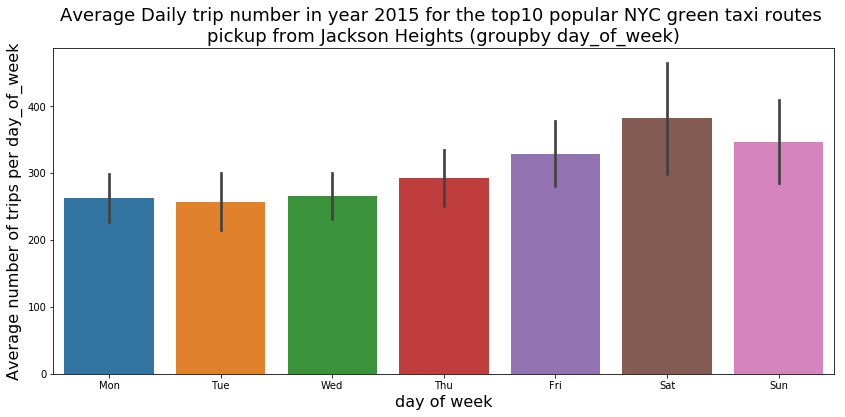

In [113]:
fig,ax = plt.subplots(figsize = (14,6))
taxi_green_gh6_trip_top10_JH_dayofweek = taxi_green_gh6_trip_top10_JH.groupby(['day_of_year','weekday'], as_index = False).sum()[['day_of_year','weekday','trip_number']]
sns.barplot(x = 'weekday', y = 'trip_number', data =taxi_green_gh6_trip_top10_JH_dayofweek, ci='sd', ax = ax)
plt.xlabel('day of week', fontsize = 16)
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
plt.ylabel('Average number of trips per day_of_week', fontsize = 16)
#plt.ylim(1000)
plt.title('Average Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Jackson Heights (groupby day_of_week)', fontsize = 18)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Hourly trip number conditioned on day_of_week for NYC green taxi \nthe top10 popular routes pickup from Jackson Heights')

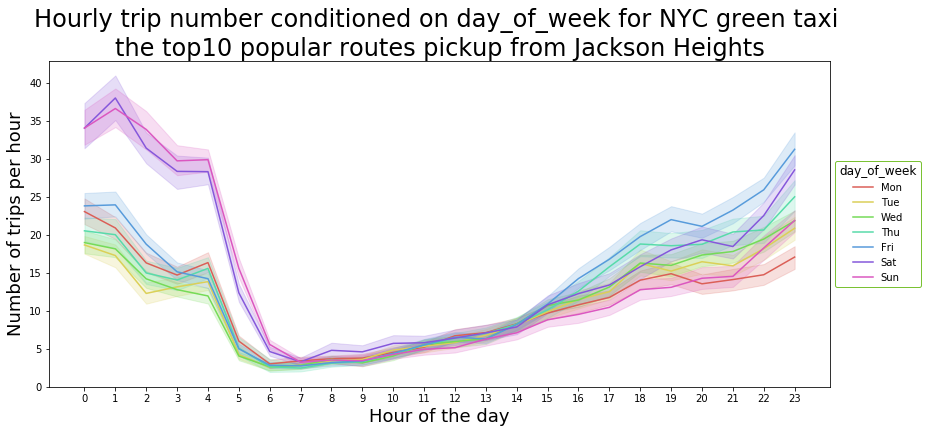

In [116]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
taxi_green_gh6_trip_top10_JH_day_hour = taxi_green_gh6_trip_top10_JH.groupby(["day_of_year","hour", "weekday"], as_index = False).sum()[["weekday", "hour", "day_of_year", "trip_number"]]
sns.lineplot(x = 'hour', y = 'trip_number', hue = 'weekday',data = taxi_green_gh6_trip_top10_JH_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24))
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Hourly trip number conditioned on day_of_week for NYC green taxi \nthe top10 popular routes pickup from Jackson Heights', fontsize = 24)

## 3.2 Routes start from McCarren Park

In [118]:
gh6_MP = taxi_green_gh6_trip_groupby_route_top10.iloc[3,:].pickup_gh6
gh6_long_MP = taxi_green_gh6_trip_groupby_route_top10.iloc[3,:].pickup_gh6_long
gh6_lat_MP = taxi_green_gh6_trip_groupby_route_top10.iloc[3,:].pickup_gh6_lat

In [122]:
gh6_MP_drop_ghs = np.array(taxi_green_gh6_trip_groupby_route_top10[taxi_green_gh6_trip_groupby_route_top10.pickup_gh6 == gh6_MP].dropoff_gh6)
print('pickup location geohash label: {}'.format(gh6_MP))
print('dropoff locations geohash label: {}'.format(gh6_MP_drop_ghs))

pickup location geohash label: dr5rth
dropoff locations geohash label: ['dr5rtn' 'dr5rsg' 'dr5rtm']


In [124]:
taxi_green_gh6_trip_top10_MP = taxi_green_gh6_trip[(taxi_green_gh6_trip.pickup_gh6==gh6_MP)&((taxi_green_gh6_trip.dropoff_gh6 == gh6_MP_drop_ghs[0])|(taxi_green_gh6_trip.dropoff_gh6 == gh6_MP_drop_ghs[1])|(taxi_green_gh6_trip.dropoff_gh6 == gh6_MP_drop_ghs[2]))]

Text(0.5, 1.0, 'Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from McCarren Park')

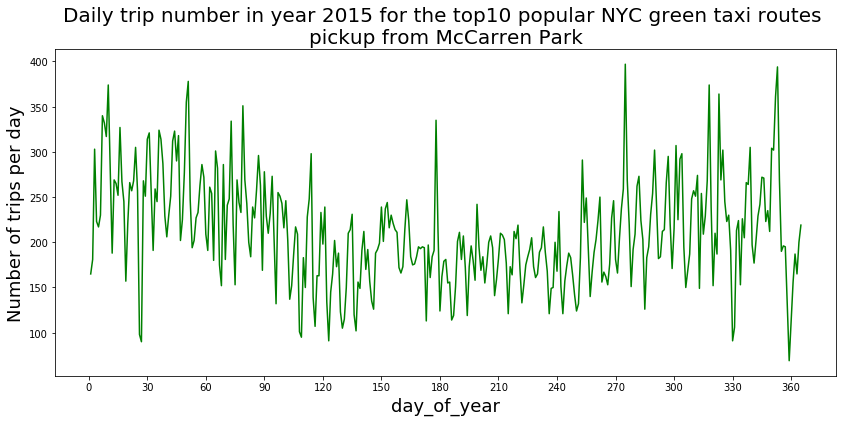

In [125]:
taxi_green_gh6_trip_top10_MP_dayofyear = taxi_green_gh6_trip_top10_MP.groupby(['day_of_year'], as_index = False).sum()[['day_of_year', 'trip_number']]
fig = plt.figure(figsize = (14,6))
plt.plot(taxi_green_gh6_trip_top10_MP_dayofyear.day_of_year, taxi_green_gh6_trip_top10_MP_dayofyear.trip_number, color = 'green')
plt.xlabel('day_of_year', fontsize = 18)
plt.ylabel('Number of trips per day', fontsize = 18)
plt.xticks(np.arange(0,365, 30))
plt.title('Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from McCarren Park', fontsize = 20)

Text(0.5, 1.0, 'Average Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from McCarren Park (groupby day_of_week)')

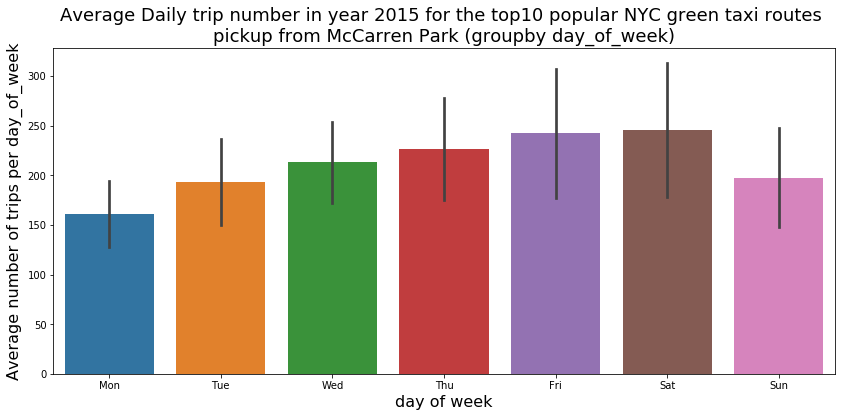

In [126]:
fig,ax = plt.subplots(figsize = (14,6))
taxi_green_gh6_trip_top10_MP_dayofweek = taxi_green_gh6_trip_top10_MP.groupby(['day_of_year','weekday'], as_index = False).sum()[['day_of_year','weekday','trip_number']]
sns.barplot(x = 'weekday', y = 'trip_number', data =taxi_green_gh6_trip_top10_MP_dayofweek, ci='sd', ax = ax)
plt.xlabel('day of week', fontsize = 16)
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
plt.ylabel('Average number of trips per day_of_week', fontsize = 16)
#plt.ylim(1000)
plt.title('Average Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from McCarren Park (groupby day_of_week)', fontsize = 18)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Hourly trip number conditioned on day_of_week for NYC green taxi \nthe top10 popular routes pickup from McCarren Park')

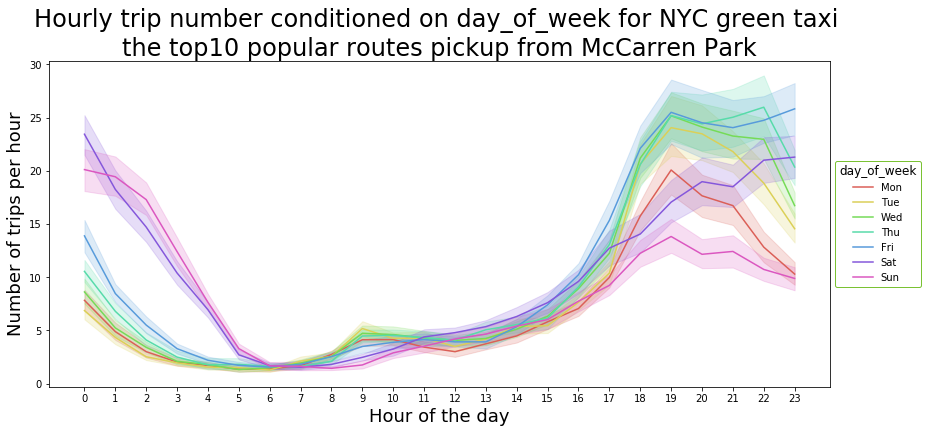

In [127]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
taxi_green_gh6_trip_top10_MP_day_hour = taxi_green_gh6_trip_top10_MP.groupby(["day_of_year","hour", "weekday"], as_index = False).sum()[["weekday", "hour", "day_of_year", "trip_number"]]
sns.lineplot(x = 'hour', y = 'trip_number', hue = 'weekday',data = taxi_green_gh6_trip_top10_MP_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24))
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Hourly trip number conditioned on day_of_week for NYC green taxi \nthe top10 popular routes pickup from McCarren Park', fontsize = 24)

## 3.3 Routes start from Harlem

In [129]:
taxi_green_gh6_trip_groupby_route_top10

,pickup_gh6,dropoff_gh6,pickup_gh6_long,pickup_gh6_lat,dropoff_gh6_long,dropoff_gh6_lat,trip_number,rank
160492,dr5ry9,dr5rye,-73.888550,40.745544,-73.888550,40.756531,30672,1
160494,dr5ry9,dr5ryg,-73.888550,40.745544,-73.877563,40.756531,30084,2
214885,dr72j1,dr5rvp,-73.954468,40.789490,-73.954468,40.778503,29711,3
108713,dr5rth,dr5rtn,-73.954468,40.718079,-73.954468,40.729065,26757,4
160493,dr5ry9,dr5ryf,-73.888550,40.745544,-73.877563,40.751038,26612,5
108676,dr5rth,dr5rsg,-73.954468,40.718079,-73.965454,40.712585,25689,6
215285,dr72j1,dr72jk,-73.954468,40.789490,-73.943481,40.805969,25391,7
108712,dr5rth,dr5rtm,-73.954468,40.718079,-73.943481,40.723572,24672,8
224906,dr72jk,dr72jj,-73.943481,40.805969,-73.954468,40.811462,24291,9
160514,dr5ry9,dr5rz4,-73.888550,40.745544,-73.866577,40.751038,24095,10


In [131]:
gh6_HA_pick_ghs = ['dr72j1','dr72j1','dr72jk']
gh6_HA_drop_ghs = ['dr5rvp','dr72jk','dr72jj']
print('pickup location geohash label: {}'.format(gh6_HA_pick_ghs))
print('dropoff locations geohash label: {}'.format(gh6_HA_drop_ghs))

pickup location geohash label: ['dr72j1', 'dr72j1', 'dr72jk']
dropoff locations geohash label: ['dr5rvp', 'dr72jk', 'dr72jj']


In [137]:
taxi_green_gh6_trip_top10_HA = taxi_green_gh6_trip[((taxi_green_gh6_trip.pickup_gh6==gh6_HA_pick_ghs[0])&(taxi_green_gh6_trip.dropoff_gh6==gh6_HA_drop_ghs[0]))|((taxi_green_gh6_trip.pickup_gh6==gh6_HA_pick_ghs[1])&(taxi_green_gh6_trip.dropoff_gh6==gh6_HA_drop_ghs[1]))|((taxi_green_gh6_trip.pickup_gh6==gh6_HA_pick_ghs[2])&(taxi_green_gh6_trip.dropoff_gh6==gh6_HA_drop_ghs[2]))]

Text(0.5, 1.0, 'Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Harlem')

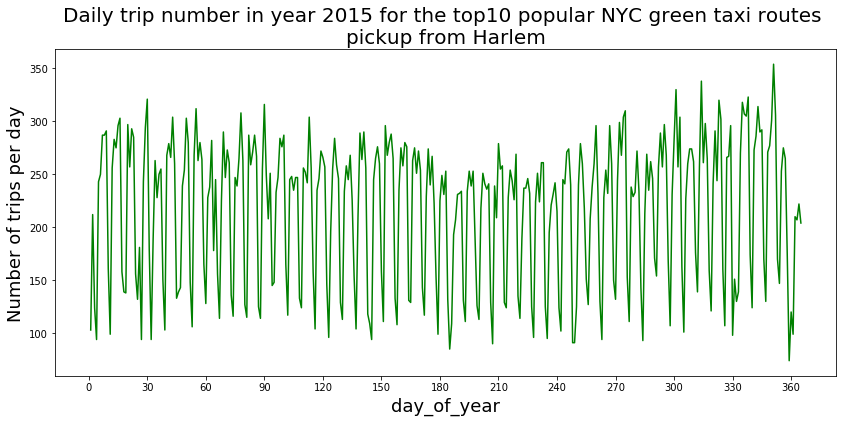

In [138]:
taxi_green_gh6_trip_top10_HA_dayofyear = taxi_green_gh6_trip_top10_HA.groupby(['day_of_year'], as_index = False).sum()[['day_of_year', 'trip_number']]
fig = plt.figure(figsize = (14,6))
plt.plot(taxi_green_gh6_trip_top10_HA_dayofyear.day_of_year, taxi_green_gh6_trip_top10_HA_dayofyear.trip_number, color = 'green')
plt.xlabel('day_of_year', fontsize = 18)
plt.ylabel('Number of trips per day', fontsize = 18)
plt.xticks(np.arange(0,365, 30))
plt.title('Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Harlem', fontsize = 20)

Text(0.5, 1.0, 'Average Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Harlem (groupby day_of_week)')

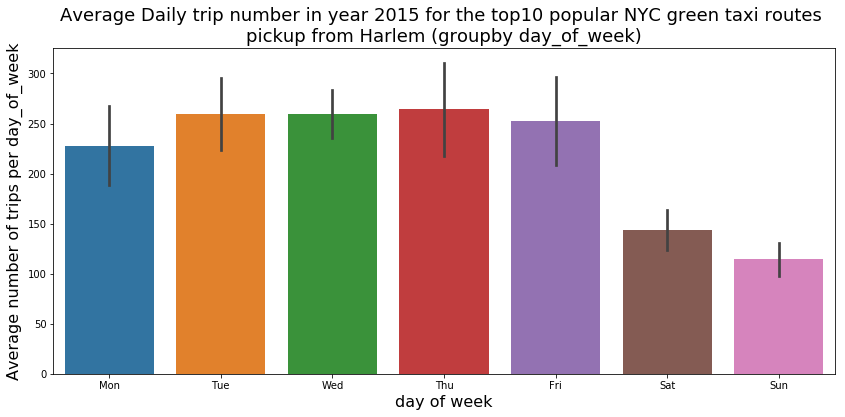

In [139]:
fig,ax = plt.subplots(figsize = (14,6))
taxi_green_gh6_trip_top10_HA_dayofweek = taxi_green_gh6_trip_top10_HA.groupby(['day_of_year','weekday'], as_index = False).sum()[['day_of_year','weekday','trip_number']]
sns.barplot(x = 'weekday', y = 'trip_number', data =taxi_green_gh6_trip_top10_HA_dayofweek, ci='sd', ax = ax)
plt.xlabel('day of week', fontsize = 16)
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
plt.ylabel('Average number of trips per day_of_week', fontsize = 16)
#plt.ylim(1000)
plt.title('Average Daily trip number in year 2015 for the top10 popular NYC green taxi routes \npickup from Harlem (groupby day_of_week)', fontsize = 18)

Text(0.5, 1.0, 'Hourly trip number conditioned on day_of_week for NYC green taxi \nthe top10 popular routes pickup from Harlem')

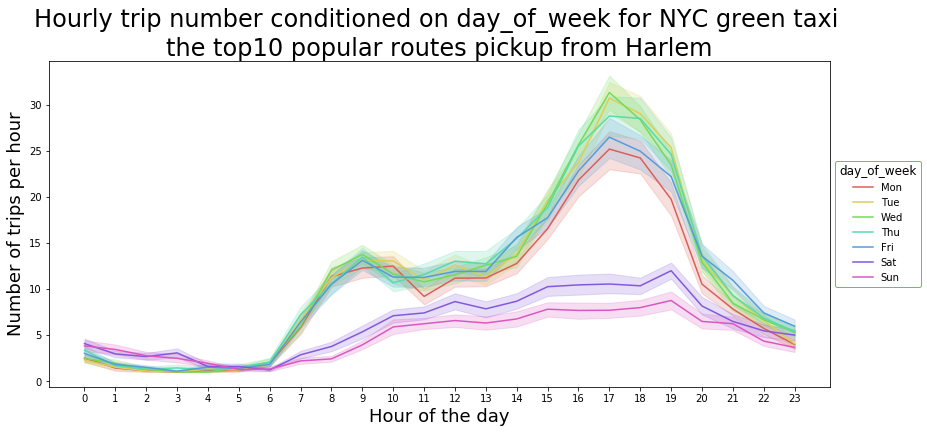

In [140]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
taxi_green_gh6_trip_top10_HA_day_hour = taxi_green_gh6_trip_top10_HA.groupby(["day_of_year","hour", "weekday"], as_index = False).sum()[["weekday", "hour", "day_of_year", "trip_number"]]
sns.lineplot(x = 'hour', y = 'trip_number', hue = 'weekday',data = taxi_green_gh6_trip_top10_HA_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24))
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Hourly trip number conditioned on day_of_week for NYC green taxi \nthe top10 popular routes pickup from Harlem', fontsize = 24)

**Summary**:
<br>1.The most popular routes are all short local trips starting from hot spots, consistent with the findings in the previous notebooks.

2.The temporal traffic density shows very different patterns for the three popular hubs. Both Jackson Heights and McCarren Park have peak traffic in the evening or late night and more trips over the weekend. Harlem has peak traffic hour around 5 pm on weekdays and the traffic plunges almost 50% over the weekend with no peak hour.

3.Jackson Heights have peak hour around 1 am on weekends compared to 11 pm on weekdays. McCarren Park has peak traffic hour between 7 pm - 10 pm over weekdays which lasts longer until midnight on Saturday and Sunday morning.

4.The distinct traffic patterns can be explained by the purposes that people visit these areas. The high traffic density in Harlem at 5 pm on weekdays suggests that the trips are more likely to be work related such as that people getting off work. The late night and weekend traffic peaks  in McCarren Park indicates that people may come to this area for relax, such as eating, drinking, or having fun.